In [27]:
import pathlib
import csv

import matplotlib.pyplot as plt

Below is a method for extracting the valid condition names, replicate numbers, file names, and column headers for all of the data located at the directory specified in the path parameter. This can be used to, for example, replicate dictionary(map) style behavior and iterate over the valid "keys" of the dictionary.

In [16]:
def get_structures(path):
    C = []
    R = []
    F = []
    H = {}
    
    conditions = pathlib.Path(path).glob("*")
    for cond_i, condition in enumerate(conditions):
        c = str(condition).split("__")[0].split("/")[-1]
        if c[0] != 'C': continue
        C.append(c)
        if cond_i == 0:
            replicates = condition.glob("*")
            for rep_i, replicate in enumerate(replicates):
                r = str(replicate).split("/")[-1]
                R.append(r)
                if rep_i == 0:
                    files = replicate.glob("*")
                    for file in files:
                        f = str(file).split("/")[-1].split(".")[0]
                        F.append(f)

                        with open(file, 'r') as dataFile:
                            csvReader = csv.reader(dataFile)
                            for row_i, row_d in enumerate(csvReader):
                                if row_i == 0:
                                    H[f] = row_d
                                    break
    return sorted(C),sorted(R),sorted(F),H


C,R,F,H = get_structures("../Data/fitness_fns")
# print(C)
# print(R)
# print(F)
# print(H)

Below is a method for accessing data in a similar manner to a dictionary(map) but without loading all of the data into RAM. Instead, the file specified by path+condition+rep+file is loaded and the column specified is extracted and returned.

In [14]:
def get_data(path,cond,rep,file,column): 
    data = []
    key = None
    
    files = pathlib.Path(path).glob("*{}*/{}/{}.csv".format(cond,rep,file)) # added * on front to be compatable
    file = [str(f) for f in files][0]                                       # with named jobs
    with open(file, 'r') as dataFile:
        csvReader = csv.reader(dataFile)
        for row_i, row_d in enumerate(csvReader):
            if row_i == 0:
                key = row_d.index(column)
                continue
            data.append(row_d[key])
    return list(map(float, data)) # TODO this will blow up if you access a list dataField

# test_x = get_data("../Data/fitness_fns","C00","101","pop","update")
# test_y = get_data("../Data/fitness_fns","C00","101","pop","score_AVE")

Below, the get_data() method is used to load the data necessary to plot each replicate of each condition in the ../Data/fitness_fns directory. From top to bottom, the number of traits is increasing from plot to plot; 1,2,4,8,16. From left to right, the length of the b-period is increasing; 0.25,0.5,0.75,1.0. Within each plot we are showing 50 replicate evolutionary runs. Each run is 100k generations long. Displayed for each replicate is the population average of "score".

shortest rep 1001 longest rep 1001
saving


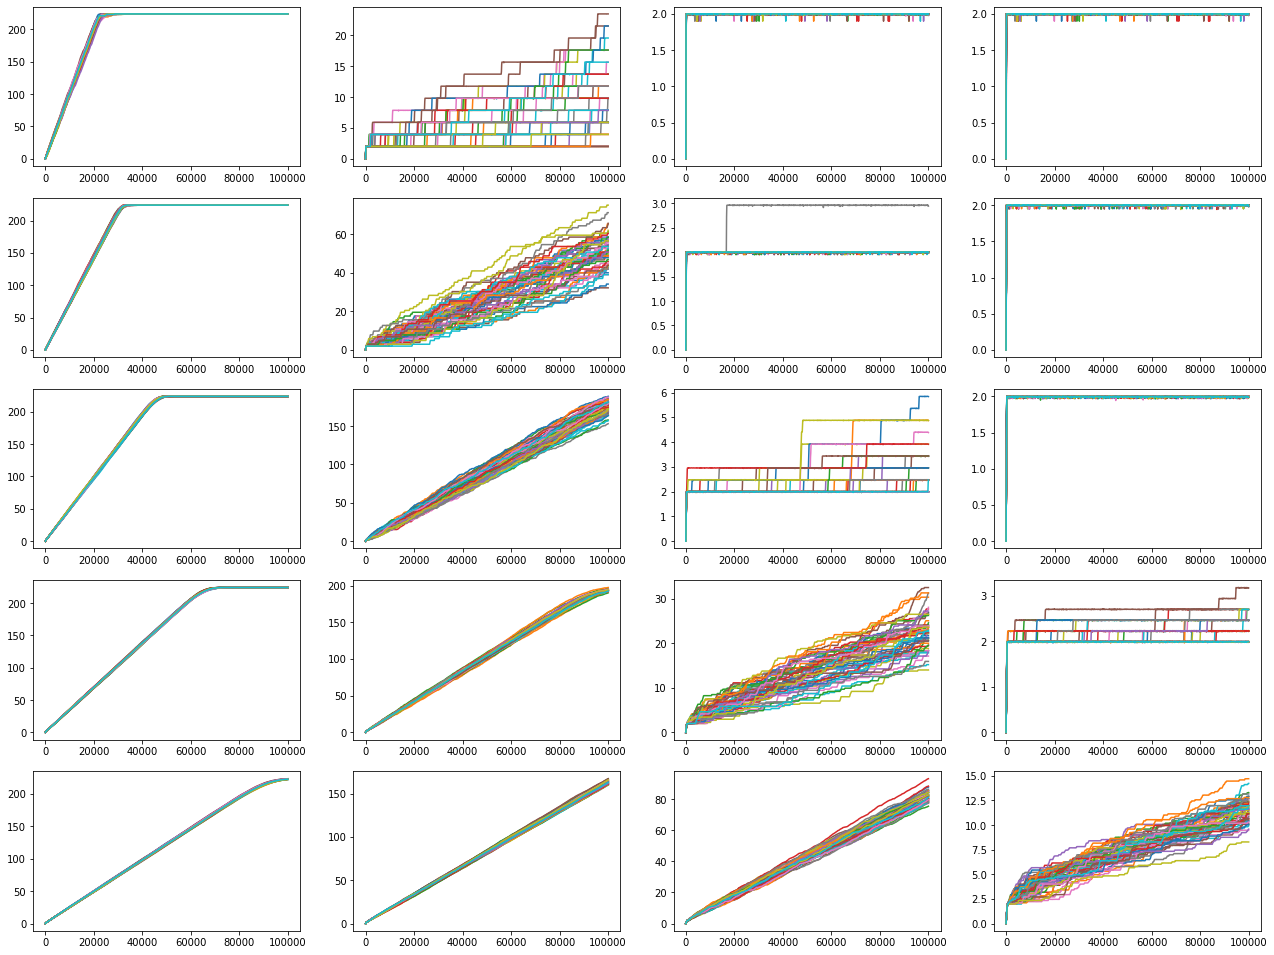

In [30]:
fig, axs = plt.subplots(5,4)
fig.set_size_inches(22, 17)
i = 0
j = 0
lens = []
for c in [str(x).zfill(2) for x in range(20)]:
    for r in range(101,151):
        x = get_data("../Data/fitness_fns","C{}".format(c),r,"LOD_data","update")
        y = get_data("../Data/fitness_fns","C{}".format(c),r,"LOD_data","score_AVE")
        lens.append(len(y))
        axs[j][i].plot(x, y)
#         axs[j][i].set_ylim(0,256)
    i += 1
    if i == 4:
        i = 0
        j += 1
print("shortest rep", min(lens), "longest rep", max(lens))
print("saving")
# plt.savefig("./FIGGIBOI.png")
plt.show()    

Below is identical code from that in the above pannel. The top row of plots show 1 trait while the bottom shows 1 6. Left to right is identical to above. Selection pressure in these plots is 16x stronger than the plots above.

shortest rep 1001 longest rep 1001
saving


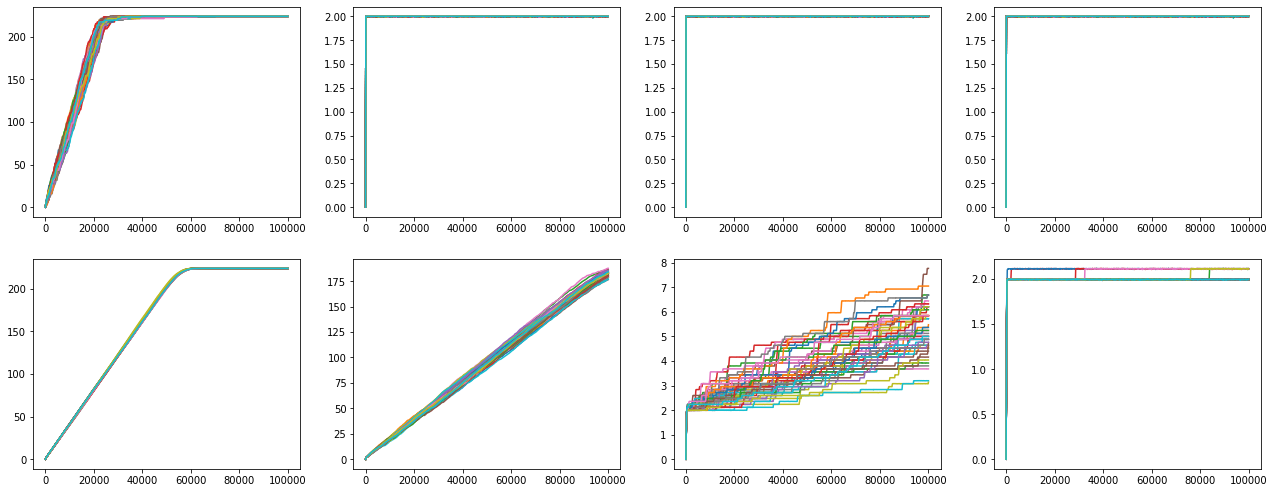

In [12]:
fig, axs = plt.subplots(2,4)
fig.set_size_inches(22, 8.5)
i = 0
j = 0
lens=[]
for c in [str(x).zfill(1) for x in range(8)]:
    for r in range(101,151):
        x = get_data("../Data/weak_16_a","C{}".format(c),r,"LOD_data","update")
        y = get_data("../Data/weak_16_a","C{}".format(c),r,"LOD_data","score_AVE")
        lens.append(len(y))
        axs[j][i].plot(x, y)
#         axs[j][i].set_ylim(0,256)
    i += 1
    if i == 4:
        i = 0
        j += 1
print("shortest rep", min(lens), "longest rep", max(lens))
print("saving")
# plt.savefig("./FIGGIBOI2.png")
plt.show()   

The code below compares reducing selection pressure by 16x vs increasing task count from 1 to 16. also with increasing population size by 16.

saving


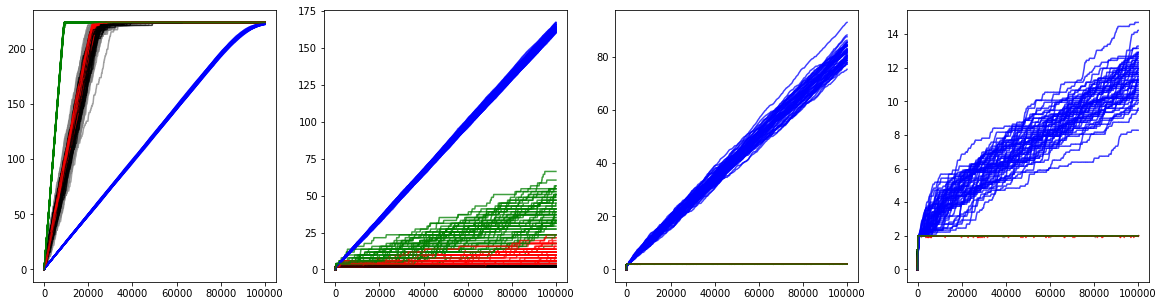

In [29]:
fig, axs = plt.subplots(1,4)
fig.set_size_inches(20, 5)

alpha = 0.75

for c in range(4):
    for r in range(151,601):
        #baseline (aditional reps, total = 16x)
        cc = str(c).zfill(1)
        x = get_data("../Data/more_reps","C{}".format(cc),r,"LOD_data","update")
        y = get_data("../Data/more_reps","C{}".format(cc),r,"LOD_data","score_AVE")
        axs[c].plot(x, y, color="grey",alpha=alpha)
        
    for r in range(101,151):
        #baseline
        cc = str(c).zfill(1)
        x = get_data("../Data/weak_16_a","C{}".format(cc),r,"LOD_data","update")
        y = get_data("../Data/weak_16_a","C{}".format(cc),r,"LOD_data","score_AVE")
        axs[c].plot(x, y, color="black",alpha=alpha)
        
        #weaker selection by 1/16
        cc = str(c).zfill(2)
        x = get_data("../Data/fitness_fns","C{}".format(cc),r,"LOD_data","update")
        y = get_data("../Data/fitness_fns","C{}".format(cc),r,"LOD_data","score_AVE")
        axs[c].plot(x, y,color="red",alpha=alpha)
        
        #16 traits
        cc = str(c+16).zfill(2)
        x = get_data("../Data/fitness_fns","C{}".format(cc),r,"LOD_data","update")
        y = get_data("../Data/fitness_fns","C{}".format(cc),r,"LOD_data","score_AVE")
        axs[c].plot(x, y,color="blue",alpha=alpha)
        
        #16x larger population
        cc = str(c).zfill(1)
        x = get_data("../Data/bigger_pop","C{}".format(cc),r,"LOD_data","update")
        y = get_data("../Data/bigger_pop","C{}".format(cc),r,"LOD_data","score_AVE")
        axs[c].plot(x, y, color="green",alpha=alpha)
        
#         axs[c].set_ylim(0,256)


print("saving")
# plt.savefig("./FIGGIBOI3.png")
plt.show()